# ***PARTA***

In [1]:
cd


/root


Moving to the input directory, so that easier to run (change it according to your system)

In [2]:
cd /kaggle/input/custom-captions-dataset-dl-tp/custom_captions_dataset

/kaggle/input/custom-captions-dataset-dl-tp/custom_captions_dataset


# Installing dependencies

In [3]:
!pip install transformers torchvision datasets evaluate pandas rouge_score bert_score
!pip uninstall -y nltk
!pip install nltk==3.5

import nltk
nltk.download('wordnet')
nltk.download('punkt')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import (
    ViTModel, GPT2LMHeadModel, ViTImageProcessor, GPT2Tokenizer,
    AutoProcessor, AutoModelForVision2Seq
)
from transformers.image_utils import load_image

import evaluate
from evaluate import load
from nltk.translate.meteor_score import meteor_score


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.0 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=bd7ddd8fd84df25b9aae06e3b5ad7e06aa32133ec39028dd1d7b8e1f57525ea8
  S

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
2025-04-13 07:47:58.831512: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744530479.005366      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744530479.057129      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Image Captioning Model + Dataset Preparation

This section defines the `ImageCaptionModel` class and the `CaptionDataset` class, along with the necessary setup for training, validation, and testing.

#### **ImageCaptionModel**
- **Encoder**: Uses a pre-trained Vision Transformer (ViT) model (`google/vit-base-patch16-224`) to extract image features.
- **Decoder**: Uses a pre-trained GPT-2 model to generate captions based on the encoded image features.
- **Processor**: Handles image preprocessing for the encoder.
- **Encoder-to-Decoder Mapping**: A linear layer maps the encoder's output to the decoder's embedding space.
- **Forward Pass**: Combines the encoder's output with the decoder's input embeddings to generate logits for caption prediction.

#### **CaptionDataset**
- Reads image-caption pairs from a CSV file.
- Preprocesses images and tokenizes captions for training.
- Returns a dictionary containing:
  - `pixel_values`: Preprocessed image tensor.
  - `input_ids`: Tokenized caption input IDs (excluding the last token).
  - `labels`: Tokenized caption labels (excluding the first token).
  - `attention_mask`: Attention mask for the input IDs.
  - `filename`: Image filename.
  - `reference`: Original caption.

#### **Setup**
- **Device**: Uses GPU if available, otherwise defaults to CPU.
- **Model**: Initializes the `ImageCaptionModel` and sets the padding token for the tokenizer.
- **Optimizer**: Uses AdamW optimizer with a learning rate of `5e-5`.
- **Loss Function**: Cross-entropy loss, ignoring the padding token.
- **Datasets**:
  - `train_dataset`: Training data.
  - `val_dataset`: Validation data.
  - `test_dataset`: Testing data.
- **DataLoaders**:
  - `train_loader`: DataLoader for training with a batch size of 8.
  - `val_loader`: DataLoader for validation with a batch size of 8.
  - `test_loader`: DataLoader for testing with a batch size of 8.

In [ ]:
class ImageCaptionModel(nn.Module):
    def __init__(self, encoder_name='google/vit-base-patch16-224', decoder_name='gpt2'):
        super(ImageCaptionModel, self).__init__()
        self.encoder = ViTModel.from_pretrained(encoder_name)
        self.tokenizer = GPT2Tokenizer.from_pretrained(decoder_name)
        self.decoder = GPT2LMHeadModel.from_pretrained(decoder_name)
        self.processor = ViTImageProcessor.from_pretrained(encoder_name)

        for param in self.encoder.parameters():
            param.requires_grad = False

        self.encoder_to_decoder = nn.Linear(
            self.encoder.config.hidden_size,
            self.decoder.config.n_embd
        )

    def forward(self, images, captions_input_ids, attention_mask):
        encoder_outputs = self.encoder(pixel_values=images)
        cls_embedding = encoder_outputs.last_hidden_state[:, 0, :] 
        encoder_proj = self.encoder_to_decoder(cls_embedding).unsqueeze(1)

        caption_embeddings = self.decoder.transformer.wte(captions_input_ids)

        decoder_inputs = torch.cat([encoder_proj, caption_embeddings], dim=1)

        extended_attention_mask = torch.cat([
            torch.ones((attention_mask.size(0), 1), device=attention_mask.device),  
            attention_mask
        ], dim=1)

        return self.decoder(
            inputs_embeds=decoder_inputs,
            attention_mask=extended_attention_mask
        ).logits[:, 1:, :]

    def encode_image(self, pil_image):
        inputs = self.processor(images=pil_image, return_tensors="pt")
        return inputs["pixel_values"]


class CaptionDataset(Dataset):
    def __init__(self, csv_path, image_dir, processor, tokenizer, max_length=32):
        self.data = pd.read_csv(csv_path)
        self.image_dir = image_dir
        self.max_length = max_length
        self.tokenizer = tokenizer
        self.processor = processor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        caption = row['caption']
        filename = row['filename']
        
        image = Image.open(os.path.join(self.image_dir, filename)).convert("RGB")

        pixel_values = self.processor(images=image, return_tensors="pt").pixel_values.squeeze(0)
        tokenized = self.tokenizer(caption, return_tensors="pt", max_length=self.max_length,
                                   padding="max_length", truncation=True)

        return {
            "pixel_values": pixel_values,
            "input_ids": tokenized.input_ids.squeeze(0)[:-1],
            "labels": tokenized.input_ids.squeeze(0)[1:],
            "attention_mask": tokenized.attention_mask.squeeze(0)[:-1],
            "filename": filename,
            "reference": caption 
        }

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImageCaptionModel().to(device)
model.tokenizer.pad_token = model.tokenizer.eos_token
optimizer = torch.optim.AdamW(model.decoder.parameters(), lr=5e-5)
loss_fn = nn.CrossEntropyLoss(ignore_index=model.tokenizer.pad_token_id)

train_dataset = CaptionDataset(
    csv_path="train.csv",
    image_dir="train",
    processor=model.processor,
    tokenizer=model.tokenizer
)
val_dataset = CaptionDataset(
    csv_path="val.csv",
    image_dir="val",
    processor=model.processor,
    tokenizer=model.tokenizer
)
test_dataset = CaptionDataset(
    csv_path="test.csv",
    image_dir="test",
    processor=model.processor,
    tokenizer=model.tokenizer
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

### Training the Image Captioning Model

This section defines the `train_model` function, which trains the `ImageCaptionModel` and evaluates it on the validation dataset after each epoch. The function also computes evaluation metrics such as BLEU, METEOR, and ROUGE-L scores.

#### **Function: `train_model`**
- **Inputs**:
  - `model`: The `ImageCaptionModel` instance.
  - `train_loader`: DataLoader for the training dataset.
  - `val_loader`: DataLoader for the validation dataset.
  - `optimizer`: Optimizer for updating model parameters (e.g., AdamW).
  - `loss_fn`: Loss function (e.g., CrossEntropyLoss).
  - `tokenizer`: Tokenizer for decoding predictions.
  - `device`: Device to run the model on (e.g., GPU or CPU).
  - `num_epochs`: Number of training epochs.

- **Outputs**:
  - Saves training loss and evaluation metrics (BLEU, METEOR, ROUGE-L) for each epoch.
  - Saves predictions and references to a CSV file after the final epoch.
  - Plots:
    - Training loss vs. epochs.
    - Evaluation metrics (BLEU, METEOR, ROUGE-L) vs. epochs.
  - Prints a summary of the evaluation metrics for all epochs.

#### **Training Process**:
1. **Training Loop**:
   - For each epoch, the model is trained on the training dataset.
   - The loss is computed using the logits from the model and the ground truth labels.
   - The optimizer updates the model parameters based on the gradients.

2. **Validation Loop**:
   - After each epoch, the model is evaluated on the validation dataset.
   - Predictions are generated using the model's decoder.
   - BLEU, METEOR, and ROUGE-L scores are computed for the predictions.

3. **Metrics and Outputs**:
   - Training loss is recorded for each epoch.
   - BLEU, METEOR, and ROUGE-L scores are computed for the validation dataset.
   - Final predictions and references are saved to a CSV file after the last epoch.
   - Plots are generated to visualize the training loss and evaluation metrics over epochs.

#### **Evaluation Metrics**:
- **BLEU**: Measures the overlap between predicted and reference captions.
- **METEOR**: Considers precision, recall, and alignment between predicted and reference captions.
- **ROUGE-L**: Measures the longest common subsequence between predicted and reference captions.

#### **Visualization**:
- **Loss vs. Epochs**: Shows how the training loss decreases over epochs.
- **Evaluation Metrics vs. Epochs**: Shows how BLEU, METEOR, and ROUGE-L scores improve over epochs.

#### **CSV Output**:
- The final predictions, references, and filenames are saved to `/kaggle/working/partA_train_output.csv`.


In [ ]:
def train_model(model, train_loader, val_loader, optimizer, loss_fn, tokenizer, device, num_epochs=1):
    train_losses = []
    bleu_scores = []
    meteor_scores = []
    rougeL_scores = []

    all_predictions = []
    all_references = []
    all_filenames = []

    bleu = evaluate.load("bleu")
    meteor = evaluate.load("meteor")
    rouge = evaluate.load("rouge")

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch in tqdm(train_loader, desc=f"[Epoch {epoch+1}] Training"):
            images = batch["pixel_values"].to(device)
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            optimizer.zero_grad()
            logits = model(images, input_ids, attention_mask)
            loss = loss_fn(logits.reshape(-1, logits.size(-1)), labels.reshape(-1))

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"[Epoch {epoch+1}] Training Loss: {avg_loss:.4f}")

        model.eval()
        predictions, references, filenames = [], [], []

        train_losses.append(avg_loss)

        for batch in tqdm(val_loader, desc=f"[Epoch {epoch+1}] Evaluating"):
            images = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)
            batch_filenames = batch["filename"]
            with torch.no_grad():
                encoder_outputs = model.encoder(pixel_values=images)
                cls_embeddings = encoder_outputs.last_hidden_state[:, 0, :]
                encoder_proj = model.encoder_to_decoder(cls_embeddings)
                encoder_proj = encoder_proj.unsqueeze(1)

                batch_size = images.size(0)
                bos_tokens = torch.full(
                    (batch_size, 1),
                    fill_value=tokenizer.bos_token_id,
                    dtype=torch.long,
                    device=device
                )
                bos_embeds = model.decoder.transformer.wte(bos_tokens)
                decoder_inputs = torch.cat([encoder_proj, bos_embeds], dim=1)
                attention_mask = torch.ones(decoder_inputs.size()[:2], device=device)

                generated_ids = model.decoder.generate(
                    inputs_embeds=decoder_inputs,
                    attention_mask=attention_mask,
                    max_length=32,
                    pad_token_id=tokenizer.eos_token_id,
                    eos_token_id=tokenizer.eos_token_id,
                    do_sample=False,
                    num_beams=3
                )

            decoded_preds = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
            decoded_refs = tokenizer.batch_decode(labels, skip_special_tokens=True)

            predictions.extend(decoded_preds)
            references.extend(decoded_refs)
            filenames.extend(batch_filenames)

        bleu_score = bleu.compute(predictions=predictions, references=[[r] for r in references])["bleu"]
        rouge_result = rouge.compute(predictions=predictions, references=references)
        meteor_score_val = meteor.compute(predictions=predictions, references=references)["meteor"]
        rougeL_score = rouge_result["rougeL"]

        bleu_scores.append(bleu_score)
        rougeL_scores.append(rougeL_score)
        meteor_scores.append(meteor_score_val)

        print(f"[Epoch {epoch+1}] BLEU: {bleu_score:.4f}")
        print(f"[Epoch {epoch+1}] METEOR: {meteor_score_val:.4f}")
        print(f"[Epoch {epoch+1}] ROUGE: {rouge_result}")

        # Save final predictions & references after the last epoch
        if epoch == num_epochs - 1:
            all_predictions = predictions
            all_references = references
            all_filenames = filenames

    # Save final predictions to CSV
    df_output = pd.DataFrame({
        "filename": all_filenames,
        "reference": all_references,
        "prediction": all_predictions
    })
    df_output.to_csv("/kaggle/working/partA_train_output.csv", index=False)

    # Plotting
    epochs = list(range(1, num_epochs + 1))

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss vs Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, bleu_scores, label="BLEU")
    plt.plot(epochs, meteor_scores, label="METEOR")
    plt.plot(epochs, rougeL_scores, label="ROUGE-L")
    plt.xlabel("Epochs")
    plt.ylabel("Score")
    plt.title("Evaluation Metrics vs Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Final Summary
    df = pd.DataFrame({
        "Epoch": epochs,
        "Loss": train_losses,
        "BLEU": bleu_scores,
        "METEOR": meteor_scores,
        "ROUGE-L": rougeL_scores
    })

    print("\nFinal Evaluation Summary:")
    print(df.to_string(index=False))


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


[Epoch 1] Training: 100%|██████████| 715/715 [03:29<00:00,  3.41it/s]


[Epoch 1] Training Loss: 2.6606


[Epoch 1] Evaluating: 100%|██████████| 119/119 [01:00<00:00,  1.96it/s]


[Epoch 1] BLEU: 0.0379
[Epoch 1] METEOR: 0.1689
[Epoch 1] ROUGE: {'rouge1': 0.30223831762826414, 'rouge2': 0.045538618792022104, 'rougeL': 0.24853955478025863, 'rougeLsum': 0.24844383779771123}


[Epoch 2] Training: 100%|██████████| 715/715 [02:56<00:00,  4.05it/s]


[Epoch 2] Training Loss: 2.3363


[Epoch 2] Evaluating: 100%|██████████| 119/119 [00:54<00:00,  2.19it/s]


[Epoch 2] BLEU: 0.0579
[Epoch 2] METEOR: 0.1920
[Epoch 2] ROUGE: {'rouge1': 0.3247017221899998, 'rouge2': 0.07592528609381749, 'rougeL': 0.25190881880496385, 'rougeLsum': 0.2518579050621721}


[Epoch 3] Training: 100%|██████████| 715/715 [02:56<00:00,  4.05it/s]


[Epoch 3] Training Loss: 2.1472


[Epoch 3] Evaluating: 100%|██████████| 119/119 [00:54<00:00,  2.19it/s]


[Epoch 3] BLEU: 0.0623
[Epoch 3] METEOR: 0.1926
[Epoch 3] ROUGE: {'rouge1': 0.3342022427223311, 'rouge2': 0.07694047280685204, 'rougeL': 0.2611125694569205, 'rougeLsum': 0.2612642631094033}


[Epoch 4] Training: 100%|██████████| 715/715 [02:56<00:00,  4.04it/s]


[Epoch 4] Training Loss: 1.9903


[Epoch 4] Evaluating: 100%|██████████| 119/119 [00:54<00:00,  2.18it/s]


[Epoch 4] BLEU: 0.0803
[Epoch 4] METEOR: 0.2129
[Epoch 4] ROUGE: {'rouge1': 0.35625981514930793, 'rouge2': 0.0950443533275365, 'rougeL': 0.2754001199322218, 'rougeLsum': 0.27519678176929097}


[Epoch 5] Training: 100%|██████████| 715/715 [02:58<00:00,  4.02it/s]


[Epoch 5] Training Loss: 1.8428


[Epoch 5] Evaluating: 100%|██████████| 119/119 [00:54<00:00,  2.17it/s]


[Epoch 5] BLEU: 0.0775
[Epoch 5] METEOR: 0.2163
[Epoch 5] ROUGE: {'rouge1': 0.3563488213374305, 'rouge2': 0.09695070995356105, 'rougeL': 0.2733179079209097, 'rougeLsum': 0.2734490091469884}


[Epoch 6] Training: 100%|██████████| 715/715 [02:57<00:00,  4.04it/s]


[Epoch 6] Training Loss: 1.7018


[Epoch 6] Evaluating: 100%|██████████| 119/119 [01:00<00:00,  1.96it/s]


[Epoch 6] BLEU: 0.0851
[Epoch 6] METEOR: 0.2253
[Epoch 6] ROUGE: {'rouge1': 0.3668838427583124, 'rouge2': 0.10500524784480494, 'rougeL': 0.2789471576409923, 'rougeLsum': 0.27901846254940527}


[Epoch 7] Training: 100%|██████████| 715/715 [03:12<00:00,  3.72it/s]


[Epoch 7] Training Loss: 1.5656


[Epoch 7] Evaluating: 100%|██████████| 119/119 [00:56<00:00,  2.10it/s]


[Epoch 7] BLEU: 0.0841
[Epoch 7] METEOR: 0.2242
[Epoch 7] ROUGE: {'rouge1': 0.36416717303282936, 'rouge2': 0.104020122824966, 'rougeL': 0.274911355431182, 'rougeLsum': 0.27486917230965513}


[Epoch 8] Training: 100%|██████████| 715/715 [03:00<00:00,  3.97it/s]


[Epoch 8] Training Loss: 1.4342


[Epoch 8] Evaluating: 100%|██████████| 119/119 [00:54<00:00,  2.17it/s]


[Epoch 8] BLEU: 0.0814
[Epoch 8] METEOR: 0.2220
[Epoch 8] ROUGE: {'rouge1': 0.3633840284842482, 'rouge2': 0.10164126388867631, 'rougeL': 0.27216305457687, 'rougeLsum': 0.2720630515374435}


[Epoch 9] Training: 100%|██████████| 715/715 [02:58<00:00,  4.01it/s]


[Epoch 9] Training Loss: 1.3100


[Epoch 9] Evaluating: 100%|██████████| 119/119 [00:54<00:00,  2.18it/s]


[Epoch 9] BLEU: 0.0703
[Epoch 9] METEOR: 0.2074
[Epoch 9] ROUGE: {'rouge1': 0.3481876811228305, 'rouge2': 0.08884818228666162, 'rougeL': 0.2632415713180345, 'rougeLsum': 0.26316536516093064}


[Epoch 10] Training: 100%|██████████| 715/715 [02:59<00:00,  3.99it/s]


[Epoch 10] Training Loss: 1.1924


[Epoch 10] Evaluating: 100%|██████████| 119/119 [00:54<00:00,  2.19it/s]


[Epoch 10] BLEU: 0.0736
[Epoch 10] METEOR: 0.2125
[Epoch 10] ROUGE: {'rouge1': 0.35379142131498287, 'rouge2': 0.09448794871167784, 'rougeL': 0.26524629753782747, 'rougeLsum': 0.26480236480549585}


[Epoch 11] Training: 100%|██████████| 715/715 [02:57<00:00,  4.02it/s]


[Epoch 11] Training Loss: 1.0844


[Epoch 11] Evaluating: 100%|██████████| 119/119 [00:54<00:00,  2.20it/s]


[Epoch 11] BLEU: 0.0684
[Epoch 11] METEOR: 0.2108
[Epoch 11] ROUGE: {'rouge1': 0.3494333480729439, 'rouge2': 0.09026894141174363, 'rougeL': 0.2607520533865376, 'rougeLsum': 0.2608174651912363}


[Epoch 12] Training: 100%|██████████| 715/715 [02:58<00:00,  4.02it/s]


[Epoch 12] Training Loss: 0.9818


[Epoch 12] Evaluating: 100%|██████████| 119/119 [00:54<00:00,  2.19it/s]


[Epoch 12] BLEU: 0.0604
[Epoch 12] METEOR: 0.1994
[Epoch 12] ROUGE: {'rouge1': 0.33201462558645534, 'rouge2': 0.0808553658591163, 'rougeL': 0.24573257200706644, 'rougeLsum': 0.2456844409899821}


[Epoch 13] Training: 100%|██████████| 715/715 [02:58<00:00,  4.01it/s]


[Epoch 13] Training Loss: 0.8923


[Epoch 13] Evaluating: 100%|██████████| 119/119 [00:54<00:00,  2.20it/s]


[Epoch 13] BLEU: 0.0602
[Epoch 13] METEOR: 0.2048
[Epoch 13] ROUGE: {'rouge1': 0.3349277784825006, 'rouge2': 0.08269416032530519, 'rougeL': 0.2470471586975309, 'rougeLsum': 0.2472299794094212}


[Epoch 14] Training: 100%|██████████| 715/715 [02:57<00:00,  4.02it/s]


[Epoch 14] Training Loss: 0.8061


[Epoch 14] Evaluating: 100%|██████████| 119/119 [00:54<00:00,  2.19it/s]


[Epoch 14] BLEU: 0.0552
[Epoch 14] METEOR: 0.1972
[Epoch 14] ROUGE: {'rouge1': 0.32916450173418954, 'rouge2': 0.076645959148986, 'rougeL': 0.24060505500671128, 'rougeLsum': 0.24071204331317939}


[Epoch 15] Training: 100%|██████████| 715/715 [02:57<00:00,  4.03it/s]


[Epoch 15] Training Loss: 0.7321


[Epoch 15] Evaluating: 100%|██████████| 119/119 [00:54<00:00,  2.18it/s]


[Epoch 15] BLEU: 0.0566
[Epoch 15] METEOR: 0.1955
[Epoch 15] ROUGE: {'rouge1': 0.3286517750332225, 'rouge2': 0.0787096063648786, 'rougeL': 0.24239086636943863, 'rougeLsum': 0.24223958188027578}


[Epoch 16] Training: 100%|██████████| 715/715 [02:57<00:00,  4.03it/s]


[Epoch 16] Training Loss: 0.6631


[Epoch 16] Evaluating: 100%|██████████| 119/119 [00:54<00:00,  2.19it/s]


[Epoch 16] BLEU: 0.0564
[Epoch 16] METEOR: 0.2002
[Epoch 16] ROUGE: {'rouge1': 0.32961126312726025, 'rouge2': 0.07793108630528991, 'rougeL': 0.24037127405785666, 'rougeLsum': 0.240281391972682}


[Epoch 17] Training: 100%|██████████| 715/715 [02:57<00:00,  4.03it/s]


[Epoch 17] Training Loss: 0.6030


[Epoch 17] Evaluating: 100%|██████████| 119/119 [00:54<00:00,  2.20it/s]


[Epoch 17] BLEU: 0.0482
[Epoch 17] METEOR: 0.1919
[Epoch 17] ROUGE: {'rouge1': 0.3182567819756707, 'rouge2': 0.06971517059562847, 'rougeL': 0.2323974150568044, 'rougeLsum': 0.23231630068521447}


[Epoch 18] Training: 100%|██████████| 715/715 [02:56<00:00,  4.05it/s]


[Epoch 18] Training Loss: 0.5442


[Epoch 18] Evaluating: 100%|██████████| 119/119 [00:54<00:00,  2.20it/s]


[Epoch 18] BLEU: 0.0501
[Epoch 18] METEOR: 0.1928
[Epoch 18] ROUGE: {'rouge1': 0.3264461069307657, 'rouge2': 0.0729151925700901, 'rougeL': 0.2385932386319205, 'rougeLsum': 0.238433315717964}


[Epoch 19] Training: 100%|██████████| 715/715 [02:56<00:00,  4.04it/s]


[Epoch 19] Training Loss: 0.4953


[Epoch 19] Evaluating: 100%|██████████| 119/119 [00:54<00:00,  2.20it/s]


[Epoch 19] BLEU: 0.0543
[Epoch 19] METEOR: 0.1961
[Epoch 19] ROUGE: {'rouge1': 0.327320852088571, 'rouge2': 0.07668152755465933, 'rougeL': 0.23967028203500249, 'rougeLsum': 0.2397363176724835}


[Epoch 20] Training: 100%|██████████| 715/715 [02:57<00:00,  4.04it/s]


[Epoch 20] Training Loss: 0.4486


[Epoch 20] Evaluating: 100%|██████████| 119/119 [00:53<00:00,  2.21it/s]


[Epoch 20] BLEU: 0.0519
[Epoch 20] METEOR: 0.1954
[Epoch 20] ROUGE: {'rouge1': 0.3272102864679245, 'rouge2': 0.0735710271664978, 'rougeL': 0.23840654018711283, 'rougeLsum': 0.2385294461457823}


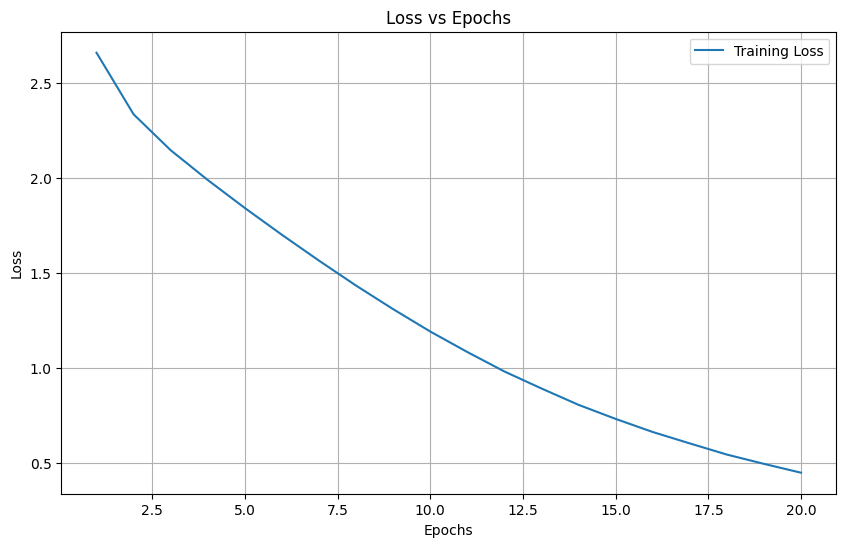

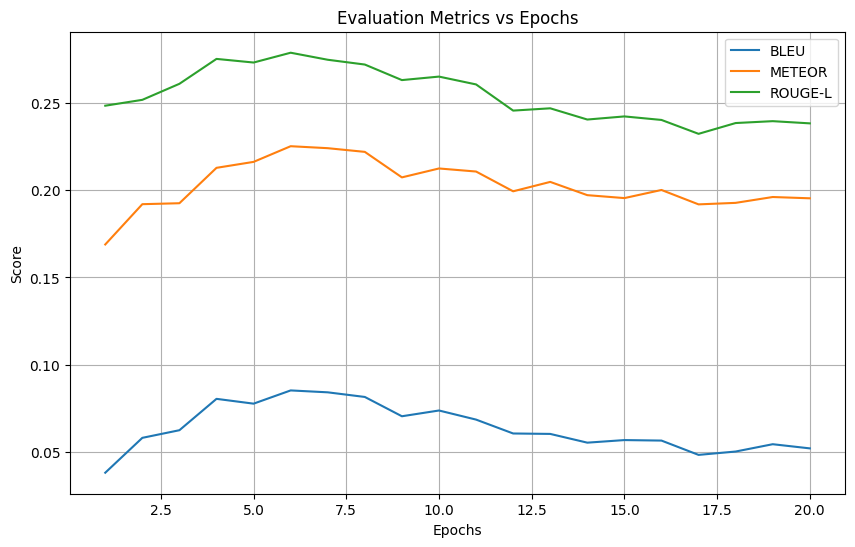


Final Evaluation Summary:
 Epoch     Loss     BLEU   METEOR  ROUGE-L
     1 2.660635 0.037914 0.168903 0.248540
     2 2.336303 0.057930 0.192026 0.251909
     3 2.147195 0.062310 0.192573 0.261113
     4 1.990257 0.080308 0.212888 0.275400
     5 1.842834 0.077548 0.216301 0.273318
     6 1.701765 0.085144 0.225294 0.278947
     7 1.565625 0.084052 0.224164 0.274911
     8 1.434160 0.081394 0.222044 0.272163
     9 1.310038 0.070319 0.207407 0.263242
    10 1.192356 0.073623 0.212521 0.265246
    11 1.084357 0.068402 0.210765 0.260752
    12 0.981805 0.060433 0.199414 0.245733
    13 0.892285 0.060186 0.204814 0.247047
    14 0.806082 0.055165 0.197206 0.240605
    15 0.732079 0.056649 0.195520 0.242391
    16 0.663099 0.056361 0.200179 0.240371
    17 0.603012 0.048152 0.191916 0.232397
    18 0.544213 0.050075 0.192783 0.238593
    19 0.495285 0.054275 0.196140 0.239670
    20 0.448630 0.051884 0.195400 0.238407


In [6]:
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    tokenizer=model.tokenizer,
    device=device,
    num_epochs=20
)

### Evaluating the Image Captioning Model

This section defines the `evaluate_model` function, which evaluates the trained `ImageCaptionModel` on the test dataset and computes evaluation metrics such as BLEU, METEOR, and ROUGE-L scores.

#### **Function: `evaluate_model`**
- **Inputs**:
  - `model`: The trained `ImageCaptionModel` instance.
  - `test_loader`: DataLoader for the test dataset.
  - `device`: Device to run the model on (e.g., GPU or CPU).

- **Outputs**:
  - Saves predictions, references, and filenames to a CSV file.
  - Prints evaluation metrics (BLEU, METEOR, ROUGE-L).
  - Returns a dictionary containing the computed metrics.

#### **Evaluation Process**:
1. **Model Evaluation**:
   - The model is set to evaluation mode (`model.eval()`).
   - For each batch in the test dataset:
     - Images are passed through the encoder to extract features.
     - The decoder generates captions based on the encoded features.
     - Predictions and references are decoded and stored.

2. **Saving Results**:
   - Predictions, references, and filenames are saved to a CSV file (`/kaggle/working/partA_test_output.csv`).

3. **Metrics Computation**:
   - **BLEU**: Measures the overlap between predicted and reference captions.
   - **METEOR**: Considers precision, recall, and alignment between predicted and reference captions.
   - **ROUGE-L**: Measures the longest common subsequence between predicted and reference captions.

#### **CSV Output**:
- The CSV file contains the following columns:
  - `filename`: The name of the image file.
  - `reference`: The ground truth caption.
  - `prediction`: The generated caption.

#### **Printed Metrics**:
- **BLEU Score**: Indicates the quality of the generated captions based on n-gram overlap.
- **METEOR Score**: Evaluates caption quality based on precision, recall, and alignment.
- **ROUGE-L Score**: Measures the longest common subsequence between predictions and references.

#### **Return Value**:
- A dictionary containing:
  - `BLEU`: The BLEU score.
  - `METEOR`: The METEOR score.
  - `ROUGE-L`: The ROUGE-L score.
  - `ROUGE`: Full ROUGE scores.

In [ ]:
rouge = load("rouge")
bleu = load("bleu")
meteor = load("meteor")

def evaluate_model(model, test_loader, device):
    model.eval()
    predictions, references, filenames = [], [], []

    for batch in tqdm(test_loader, desc="Evaluating Test Set"):
        images = batch["pixel_values"].to(device)         
        labels = batch["labels"].to(device)               
        batch_filenames = batch["filename"]               

        with torch.no_grad():
            encoder_outputs = model.encoder(pixel_values=images)
            cls_embeddings = encoder_outputs.last_hidden_state[:, 0, :]           
            encoder_proj = model.encoder_to_decoder(cls_embeddings).unsqueeze(1) 

        batch_size = images.size(0)
        bos_tokens = torch.full(
            (batch_size, 1),
            fill_value=model.tokenizer.bos_token_id,
            dtype=torch.long,
            device=device
        ) 
        bos_embeds = model.decoder.transformer.wte(bos_tokens) 

        decoder_inputs = torch.cat([encoder_proj, bos_embeds], dim=1) 
        attention_mask = torch.ones(decoder_inputs.size()[:2], device=device)   

        with torch.no_grad():
            generated_ids = model.decoder.generate(
                inputs_embeds=decoder_inputs,
                attention_mask=attention_mask,
                max_length=32,
                pad_token_id=model.tokenizer.eos_token_id,
                eos_token_id=model.tokenizer.eos_token_id,
                do_sample=False,      
                num_beams=3           
            )

        decoded_preds = model.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

        decoded_refs = model.tokenizer.batch_decode(labels, skip_special_tokens=True)

        predictions.extend(decoded_preds)
        filenames.extend(batch_filenames)
        references.extend(decoded_refs)

    # Save predictions, references, filenames to CSV
    df_test_output = pd.DataFrame({
        "filename": filenames,
        "reference": references,
        "prediction": predictions
    })
    df_test_output.to_csv("/kaggle/working/partA_test_output.csv", index=False)

    # Compute evaluation metrics
    bleu_score = bleu.compute(predictions=predictions, references=[[ref] for ref in references])["bleu"]
    meteor_score_val = meteor.compute(predictions=predictions, references=references)["meteor"]
    rouge_result = rouge.compute(predictions=predictions, references=references)
    rougeL_score = rouge_result["rougeL"]

    print(f"BLEU: {bleu_score:.4f}")
    print(f"METEOR: {meteor_score_val:.4f}")
    print(f"ROUGE-L: {rougeL_score:.4f}")
    print(f"Full ROUGE Scores: {rouge_result}")

    return {
        "BLEU": bleu_score,
        "METEOR": meteor_score_val,
        "ROUGE-L": rougeL_score,
        "ROUGE": rouge_result
    }

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
test_metrics = evaluate_model(model, test_loader, device)

Evaluating Test Set: 100%|██████████| 116/116 [00:57<00:00,  2.01it/s]


BLEU: 0.0527
METEOR: 0.1947
ROUGE-L: 0.2385
Full ROUGE Scores: {'rouge1': 0.32677393338411825, 'rouge2': 0.0731944801865365, 'rougeL': 0.23850877443696533, 'rougeLsum': 0.23859072664005232}


Basic Global for the SMOLVLM model

In [9]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CSV_PATH = "test.csv"
IMAGE_FOLDER = "test"

MODEL_NAME = "HuggingFaceTB/SmolVLM-Instruct"
CAPTION_PROMPT = "Without paragraphs describe the image in less words."


### Zero-Shot Image Captioning and Metrics Computation (on SMOLVLM)

This section defines the `zero_shot_captioning` class and related functions to generate captions for images using a pre-trained model and compute evaluation metrics.

#### **Class: `zero_shot_captioning`**
- **Initialization**:
  - Loads a pre-trained vision-to-sequence model (`AutoModelForVision2Seq`) and processor (`AutoProcessor`) from Hugging Face.
  - Sets the device (CUDA or CPU) and prepares a captioning prompt using the provided template.
- **Method: `caption`**:
  - Takes an image path as input and generates a caption using the model.
  - Returns the generated caption as a string.

#### **Function: `compute_metrics`**
- Computes evaluation metrics for generated captions:
  - **BLEU**: Measures n-gram overlap between predictions and references.
  - **ROUGE-L**: Measures the longest common subsequence between predictions and references.
  - **METEOR**: Considers precision, recall, and alignment between predictions and references.
- Prints the computed metrics.

#### **Function: `generate_all_captions`**
- **Inputs**:
  - `captioner`: An instance of the `zero_shot_captioning` class.
  - `csv_path`: Path to the CSV file containing image filenames and reference captions.
  - `image_dir`: Directory containing the images.
- **Outputs**:
  - Generates captions for all images in the dataset.
  - Saves the results (filenames, reference captions, and predictions) to a CSV file (`/kaggle/working/SMOL_PARTA_outputs.csv`).
  - Returns the predictions, references, and the output DataFrame.

#### **Process**:
1. **Caption Generation**:
   - Iterates through the dataset, generating captions for each image using the `captioner`.
   - Handles cases where caption generation fails by appending an empty string.
2. **Saving Results**:
   - Saves the generated captions, references, and filenames to a CSV file.
3. **Metrics Computation**:
   - Use the `compute_metrics` function to evaluate the generated captions against the references.

#### **CSV Output**:
- The CSV file contains the following columns:
  - `filename`: The name of the image file.
  - `reference`: The ground truth caption.
  - `prediction`: The generated caption.


In [ ]:
class zero_shot_captioning:
    def __init__(self, model_name=MODEL_NAME, device=DEVICE, prompt=CAPTION_PROMPT):
        self.device = device
        self.processor = AutoProcessor.from_pretrained(model_name)
        self.model = AutoModelForVision2Seq.from_pretrained(
            model_name,
            torch_dtype=torch.bfloat16 if device == "cuda" else torch.float32,
            _attn_implementation="eager"
        ).to(device).eval()

        self.prompt = self.processor.apply_chat_template(
            [{
                "role": "user",
                "content": [
                    {"type": "image"},
                    {"type": "text", "text": prompt}
                ]
            }],
            add_generation_prompt=True
        )

    def caption(self, image_path: str, max_tokens: int = 80) -> str:
        image = load_image(image_path)
        inputs = self.processor(text=self.prompt, images=image, return_tensors="pt").to(self.device)
        with torch.inference_mode():
            generated_ids = self.model.generate(**inputs, max_new_tokens=max_tokens)
        caption = self.processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        torch.cuda.empty_cache()
        return caption.strip()

def compute_metrics(predictions, references):
    bleu_score = evaluate.load("bleu").compute(predictions=predictions, references=[[r] for r in references])
    rouge_score = evaluate.load("rouge").compute(predictions=predictions, references=references)
    meteor_avg = sum(meteor_score([ref], pred) for ref, pred in zip(references, predictions)) / len(predictions)

    print(f"BLEU:     {bleu_score['bleu']:.4f}")
    print(f"ROUGE-L:  {rouge_score['rougeL']:.4f}")
    print(f"METEOR:   {meteor_avg:.4f}")

def generate_all_captions(captioner: zero_shot_captioning, csv_path: str, image_dir: str):
    df = pd.read_csv(csv_path).dropna()
    predictions, references = [], []

    print("Generating captions...")

    for _, row in tqdm(df.iterrows(), total=len(df), desc="Captioning"):
        ip = f"{image_dir}/{row['filename']}"
        generated = captioner.caption(ip)
        
        if generated:
            predictions.append(generated)
            references.append(row['caption'])
        else:
            predictions.append("")  # In case generation fails
            references.append(row['caption'])

    output_df = pd.DataFrame({
        "filename": df["filename"],
        "reference": references,
        "prediction": predictions
    })

    # Save to CSV
    output_df.to_csv("/kaggle/working/SMOL_PARTA_outputs.csv", index=False)
    print("Saved results to /kaggle/working/SMOL_PARTA_outputs.csv")

    return predictions, references, output_df


In [11]:
captioner = zero_shot_captioning()
predictions, references, df = generate_all_captions(captioner, CSV_PATH, IMAGE_FOLDER)
compute_metrics(predictions, references)


processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/429 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/486 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.48k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/801k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.52M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/92.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/7.45k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.49G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

Generating captions...


Captioning: 100%|██████████| 928/928 [1:47:53<00:00,  6.98s/it]


Saved results to /kaggle/working/SMOL_PARTA_outputs.csv
BLEU:     0.0066
ROUGE-L:  0.1299
METEOR:   0.0790


## PART-B

In [ ]:
import base64

import torch
from torch.utils.data import DataLoader
from torchvision import transforms

from IPython.display import HTML


### Evaluating Model Performance on Occluded Images

This section defines functions to evaluate the model's performance on images with varying levels of occlusion. The occlusion simulates missing parts of the image to test the robustness of the model.

#### **Function: `occlude_image`**
- **Purpose**: Applies a patch-based occlusion to an image.
- **Inputs**:
  - `image`: The input image as a NumPy array.
  - `mask_percent`: Percentage of the image to occlude.
- **Outputs**:
  - Returns the occluded image as a NumPy array.

#### **Function: `create_download_link`**
- **Purpose**: Creates a downloadable link for a CSV file.
- **Inputs**:
  - `df`: The DataFrame to save as a CSV.
  - `title`: The title of the download link.
  - `filename`: The name of the CSV file.
- **Outputs**:
  - Returns an HTML link for downloading the CSV.

#### **Function: `evaluate_on_occluded_images`**
- **Purpose**: Evaluates the model's performance on occluded images.
- **Inputs**:
  - `model`: The trained image captioning model.
  - `tokenizer`: The tokenizer for decoding predictions.
  - `dataloader`: DataLoader for the test dataset.
  - `device`: Device to run the model on (e.g., GPU or CPU).
  - `occlusion_levels`: List of occlusion percentages to test.
- **Outputs**:
  - Saves the evaluation results to a CSV file (`/kaggle/working/partB_custom.csv`).
  - Returns the DataFrame of results and a download link.

#### **Process**:
1. **Occlusion Application**:
   - For each occlusion level, patches of the image are masked based on the specified percentage.
2. **Caption Generation**:
   - The occluded image is passed through the model to generate captions.
3. **Metrics Computation**:
   - **BLEU**: Measures n-gram overlap between predictions and references.
   - **ROUGE-L**: Measures the longest common subsequence between predictions and references.
   - **METEOR**: Considers precision, recall, and alignment between predictions and references.
4. **Saving Results**:
   - Results (filenames, occlusion levels, predictions, references) are saved to a CSV file.

#### **CSV Output**:
- The CSV file contains the following columns:
  - `filename`: The name of the image file.
  - `occlusion_level`: The percentage of the image occluded.
  - `predicted_caption`: The caption generated by the model.
  - `reference_caption`: The ground truth caption.


In [ ]:
def occlude_image(image: np.ndarray, mask_percent: int) -> np.ndarray:
    h, w, c = image.shape
    patch_size = 16
    occluded_image = image.copy()

    x_coords = np.arange(0, w, patch_size)
    y_coords = np.arange(0, h, patch_size)
    all_coords = [(x, y) for y in y_coords for x in x_coords]

    total_patches = len(all_coords)
    num_to_mask = int((mask_percent / 100) * total_patches)
    masked_indices = np.random.choice(total_patches, size=num_to_mask, replace=False)

    for idx in masked_indices:
        x, y = all_coords[idx]
        x_end = min(x + patch_size, w)
        y_end = min(y + patch_size, h)
        occluded_image[y:y_end, x:x_end] = 0

    return occluded_image

def create_download_link(df, title="Download CSV", filename="data.csv"):
    csv_data = df.to_csv(index=False)
    b64_data = base64.b64encode(csv_data.encode()).decode()

    html_link = HTML(f'''
        <a download="{filename}" 
           href="data:text/csv;base64,{b64_data}" 
           target="_blank"
           style="
               display:inline-block;
               padding:8px 16px;
               background-color:#4CAF50;
               color:white;
               text-decoration:none;
               border-radius:5px;
               font-weight:bold;
           ">
           {title}
        </a>
    ''')
    return html_link

def evaluate_on_occluded_images(model, tokenizer, dataloader, device, occlusion_levels):
    model.eval()

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    rouge = evaluate.load("rouge")
    bleu = evaluate.load("bleu")
    meteor = evaluate.load("meteor")

    all_results = []

    for level in occlusion_levels:
        results = []
        predictions, references = [], []

        for batch in tqdm(dataloader, desc=f"Occlusion {level}%"):
            filenames = batch["filename"]
            images = batch["pixel_values"]
            refs = batch["reference"]

            for i in range(len(images)):
                img_x = np.array(transforms.ToPILImage()(images[i]))

                occluded_pil = Image.fromarray(occlude_image(img_x, level))
                input_tensor = transform(occluded_pil).unsqueeze(0).to(device)

                with torch.no_grad():
                    encoder_out = model.encoder(pixel_values=input_tensor)
                    encoder_out = encoder_out.last_hidden_state[:, 0, :]

                    encoder_proj = model.encoder_to_decoder(encoder_out)
                    encoder_proj = encoder_proj.unsqueeze(1)

                    bos_token = torch.full((1, 1), model.tokenizer.bos_token_id, dtype=torch.long).to(device)
                    bos_embed = model.decoder.transformer.wte(bos_token)

                    decoder_input = torch.cat([encoder_proj, bos_embed], dim=1)
                    attention_mask = torch.ones(decoder_input.size()[:2], device=device)

                    generated_ids = model.decoder.generate(
                        inputs_embeds=decoder_input,
                        attention_mask=attention_mask,
                        max_length=32,
                        pad_token_id=model.tokenizer.eos_token_id,
                        eos_token_id=model.tokenizer.eos_token_id,
                        do_sample=False,
                        num_beams=3
                    )

                decoded_caption = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

                predictions.append(decoded_caption)
                references.append(refs[i])
                results.append({
                    "filename": filenames[i],
                    "occlusion_level": level,
                    "predicted_caption": decoded_caption,
                    "reference_caption": refs[i]
                })

        rouge_score = rouge.compute(predictions=predictions, references=references)["rougeL"]
        meteor_score_val = sum(meteor_score([ref], pred) for ref, pred in zip(references, predictions)) / len(predictions)
        bleu_score = bleu.compute(predictions=predictions, references=[[ref] for ref in references])["bleu"]

        print(f"\nOcclusion Level {level}%")
        print(f"BLEU:     {bleu_score:.4f}")
        print(f"ROUGE-L:  {rouge_score:.4f}")
        print(f"METEOR:   {meteor_score_val:.4f}")

        all_results.extend(results)

    df = pd.DataFrame(all_results)
    output_path = "/kaggle/working/partB_custom.csv"
    df.to_csv(output_path, index=False)
    print(f"\nSaved CSV to {output_path}")

    return df, create_download_link(df, title="Download partB_custom.csv", filename="partB_custom.csv")


In [14]:
occlusion_levels = [10, 50, 80]
df, download_link = evaluate_on_occluded_images(model, model.tokenizer, test_loader, device, occlusion_levels)
display(download_link)


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Occlusion 10%: 100%|██████████| 116/116 [05:15<00:00,  2.72s/it]



Occlusion Level 10%
BLEU:     0.0202
ROUGE-L:  0.2124
METEOR:   0.1371


Occlusion 50%: 100%|██████████| 116/116 [05:15<00:00,  2.72s/it]



Occlusion Level 50%
BLEU:     0.0174
ROUGE-L:  0.2018
METEOR:   0.1283


Occlusion 80%: 100%|██████████| 116/116 [05:16<00:00,  2.73s/it]



Occlusion Level 80%
BLEU:     0.0141
ROUGE-L:  0.1928
METEOR:   0.1203

Saved CSV to /kaggle/working/partB_custom.csv


### Evaluating SMOLVLM Model Performance on Occluded Images

This section defines the `evaluate_with_smolvlm` function, which evaluates the SMOLVLM model's performance on images with varying levels of occlusion. The function generates captions for occluded images and computes evaluation metrics.

#### **Function: `evaluate_with_smolvlm`**
- **Purpose**: Evaluates the SMOLVLM model's performance on occluded images.
- **Inputs**:
  - `dataloader`: DataLoader for the test dataset.
  - `device`: Device to run the model on (e.g., GPU or CPU).
  - `occlusion_levels`: List of occlusion percentages to test.
  - `captioner`: An instance of the `zero_shot_captioning` class.
- **Outputs**:
  - Saves the evaluation results to a CSV file (`/kaggle/working/output_smolvlm_partb.csv`).
  - Returns the DataFrame of results and a download link.

#### **Process**:
1. **Occlusion Application**:
   - For each occlusion level, patches of the image are masked based on the specified percentage.
2. **Caption Generation**:
   - The occluded image is passed through the SMOLVLM model to generate captions.
3. **Metrics Computation**:
   - **BLEU**: Measures n-gram overlap between predictions and references.
   - **ROUGE-L**: Measures the longest common subsequence between predictions and references.
   - **METEOR**: Considers precision, recall, and alignment between predictions and references.
4. **Saving Results**:
   - Results (filenames, occlusion levels, predictions, references) are saved to a CSV file.

#### **CSV Output**:
- The CSV file contains the following columns:
  - `filename`: The name of the image file.
  - `occlusion_level`: The percentage of the image occluded.
  - `smolvlm_caption`: The caption generated by the SMOLVLM model.
  - `reference_caption`: The ground truth caption.


In [ ]:
def evaluate_with_smolvlm(dataloader, device, occlusion_levels, captioner: zero_shot_captioning):
    all_results = []

    for level in occlusion_levels:
        references = []
        predictions = []
        results = []

        for batch in tqdm(dataloader, desc=f"SMOLVLM Occlusion {level}%"):
            refs = batch["reference"]
            filenames = batch["filename"]
            images = batch["pixel_values"]

            for i in range(len(images)):

                img_y = np.array(transforms.ToPILImage()(images[i]))

                generated_caption = captioner.caption(Image.fromarray(occlude_image(img_y, level)))

                predictions.append(generated_caption)
                references.append(refs[i])
                results.append({
                    "filename": filenames[i],
                    "occlusion_level": level,
                    "smolvlm_caption": generated_caption,
                    "reference_caption": refs[i]
                })

        bleu_score = evaluate.load("bleu").compute(predictions=predictions, references=[[ref] for ref in references])["bleu"]
        rouge_score = evaluate.load("rouge").compute(predictions=predictions, references=references)["rougeL"]
        meteor_val = sum(meteor_score([ref], pred) for ref, pred in zip(references, predictions)) / len(predictions)

        print(f"\nSMOLVLM Evaluation @ {level}% Occlusion")
        print(f"BLEU:    {bleu_score:.4f}")
        print(f"ROUGE-L: {rouge_score:.4f}")
        print(f"METEOR:  {meteor_val:.4f}")
        print("-" * 50)

        all_results.extend(results)

    df = pd.DataFrame(all_results)

    output_path = "/kaggle/working/output_smolvlm_partb.csv"
    df.to_csv(output_path, index=False)
    print(f"\nSaved CSV to {output_path}")

    download_link = create_download_link(df, title="Download output_smolvlm_partb.csv", filename="output_smolvlm_partb.csv")
    return df, download_link


In [16]:
occlusion_levels2 = [10, 50, 80]
df2, download_link2 = evaluate_with_smolvlm(test_loader, device="cuda", occlusion_levels=occlusion_levels2, captioner=captioner)
display(download_link2)

SMOLVLM Occlusion 10%: 100%|██████████| 116/116 [2:18:07<00:00, 71.44s/it]



SMOLVLM Evaluation @ 10% Occlusion
BLEU:    0.0101
ROUGE-L: 0.1318
METEOR:  0.0861
--------------------------------------------------


SMOLVLM Occlusion 50%: 100%|██████████| 116/116 [2:15:46<00:00, 70.23s/it]



SMOLVLM Evaluation @ 50% Occlusion
BLEU:    0.0033
ROUGE-L: 0.1031
METEOR:  0.0573
--------------------------------------------------


SMOLVLM Occlusion 80%: 100%|██████████| 116/116 [2:14:35<00:00, 69.61s/it]



SMOLVLM Evaluation @ 80% Occlusion
BLEU:    0.0006
ROUGE-L: 0.0744
METEOR:  0.0379
--------------------------------------------------

Saved CSV to /kaggle/working/output_smolvlm_partb.csv
